In [31]:
import os
import pandas as pd
import numpy as np
import cv2
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random

from tqdm.notebook import tqdm as pbar

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, schedules
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
dataset_dir = '/kaggle/input/faceexpression-dp'
image_dir = '/kaggle/input/faceexpression-dp/dataset'
csv_dir = os.path.join(dataset_dir,'data.csv')

In [3]:
print(dataset_dir)
print(image_dir)
print(csv_dir)

/kaggle/input/faceexpression-dp
/kaggle/input/faceexpression-dp/dataset
/kaggle/input/faceexpression-dp/data.csv


In [4]:
data = pd.read_csv(csv_dir,index_col=0)

In [5]:
data.shape

(15453, 2)

In [6]:
data['path'] = data['path'].apply(lambda x: os.path.join('/kaggle/input/faceexpression-dp/dataset', x))

In [7]:
data.head(5)

,path,label
0,/kaggle/input/faceexpression-dp/dataset/Surpri...,Surprise
1,/kaggle/input/faceexpression-dp/dataset/Surpri...,Surprise
2,/kaggle/input/faceexpression-dp/dataset/Surpri...,Surprise
3,/kaggle/input/faceexpression-dp/dataset/Surpri...,Surprise
4,/kaggle/input/faceexpression-dp/dataset/Surpri...,Surprise


sample the dataset number of images per expression

In [8]:
## Balance the dataset to have 1000 samples per class
#data = data.groupby('label').apply(lambda x: x.sample(n=700, replace=True)).reset_index(drop=True)


In [9]:
data['label'].value_counts()

label
Neutral     4027
Sad         3934
Happy       3740
Angry       1313
Surprise    1234
Ahegao      1205
Name: count, dtype: int64

In [10]:
ahegao_img_dir = os.path.join(image_dir,'Ahegao')
angry_img_dir = os.path.join(image_dir,'Angry')
happy_img_dir = os.path.join(image_dir,'Happy')
neutral_img_dir = os.path.join(image_dir,'Neutral')
sad_img_dir = os.path.join(image_dir,'Sad')
surprise_img_dir = os.path.join(image_dir,'Surprise')

#ahegao in image folder
ahegao_images = set(os.listdir(ahegao_img_dir))
print("Total Ahegao images in folder:",len(ahegao_images))

#angry in image folder
angry_images = set(os.listdir(angry_img_dir))
print("Total Angry images in folder:",len(angry_images))
#happy in image folder
happy_images = set(os.listdir(happy_img_dir))
print("Total Happy images in folder:",len(happy_images))
#neutral in image folder
neutral_images = set(os.listdir(neutral_img_dir))
print("Total Neutral images in folder:",len(neutral_images))
#sad in image folder
sad_images = set(os.listdir(sad_img_dir))
print("Total Sad images in folder:",len(sad_images))
#surprise in image folder
surprise_images = set(os.listdir(surprise_img_dir))
print("Total Surprise images in folder:",len(surprise_images))

#Total images in dataset folder
total_images = len(ahegao_images)+len(angry_images)+len(happy_images)+len(neutral_images)+len(sad_images)+len(surprise_images)
print("Total images in dataset folder",total_images)

Total Ahegao images in folder: 1205
Total Angry images in folder: 1313
Total Happy images in folder: 3740
Total Neutral images in folder: 4027
Total Sad images in folder: 3934
Total Surprise images in folder: 1234
Total images in dataset folder 15453


In [11]:
img = cv2.imread('/kaggle/input/faceexpression-dp/dataset/Angry/00a7cb9cf18d3a015a9e932952f942fd4bcad8044bcef5e0c05de51d~angry.jpg')

In [12]:
img.shape

(364, 364, 3)

plot image of each respectful classes

In [13]:
#define image size and parameters
IMG_SIZE = (224,224)
BATCH_SIZE = 32
NUM_CLASSES = 6
EPOCHS = 20

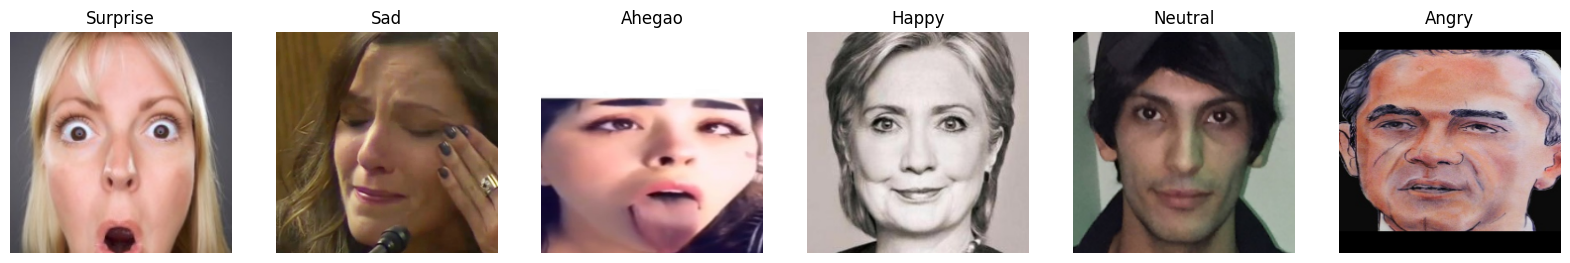

In [14]:

# Function to plot one random image per expression
def plot_random_images_per_expression(data, img_size):
    expressions = data['label'].unique()
    fig, axes = plt.subplots(1, len(expressions), figsize=(20, 5))

    for ax, expression in zip(axes, expressions):
        random_img_path = random.choice(data[data['label'] == expression]['path'].values)
        image = cv2.imread(random_img_path)
        image = cv2.resize(image, img_size)  # Resize to the same size used for the model
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
        
        ax.imshow(image)
        ax.set_title(expression)
        ax.axis('off')

    plt.show()

# Call the function with your DataFrame and image size
plot_random_images_per_expression(data, IMG_SIZE)


In [15]:
#data preprocessing function
def preprocessing_image(img_path):
    image = cv2.imread(img_path)
    image = cv2.resize(image,IMG_SIZE) #Resize image to (224,224)
    image = cv2.GaussianBlur(image, (5,5), 0) #apply gaussian blur
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale
    image = cv2.equalizeHist(image) # histogram equalization
    _, image = cv2.threshold(image,128,255,cv2.THRESH_BINARY) # thresholding
    image = np.stack((image,)*3,axis=-1) #convert grayscale to 3 channels (RGB)
    return image.astype(np.float32) /255.0 #normalize to [0,1]

from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocessing_image_vgg(image):
    #print(img_path)
    #image = cv2.imread(img_path)  # Read the image
    image = cv2.resize(image, (224, 224))  # Resize image to (224, 224)
    # Gaussian blur and other augmentations (if needed)
    image = cv2.GaussianBlur(image, (5, 5), 0)  # Apply Gaussian blur
    # Normalize using VGG preprocessing (subtract mean, divide by std)
    image = preprocess_input(image)
    return image


In [16]:
# Split data into training and validation sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
print(train_data.head())
print(test_data.head())

                                                    path    label
11468  /kaggle/input/faceexpression-dp/dataset/Neutra...  Neutral
3813   /kaggle/input/faceexpression-dp/dataset/Sad/5b...      Sad
8535   /kaggle/input/faceexpression-dp/dataset/Happy/...    Happy
13205  /kaggle/input/faceexpression-dp/dataset/Neutra...  Neutral
8061   /kaggle/input/faceexpression-dp/dataset/Happy/...    Happy
                                                    path    label
2573   /kaggle/input/faceexpression-dp/dataset/Sad/6a...      Sad
12156  /kaggle/input/faceexpression-dp/dataset/Neutra...  Neutral
3100   /kaggle/input/faceexpression-dp/dataset/Sad/cr...      Sad
5045   /kaggle/input/faceexpression-dp/dataset/Sad/3f...      Sad
3457   /kaggle/input/faceexpression-dp/dataset/Sad/5e...      Sad


In [17]:
#Image Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_image_vgg,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    rescale = 1./255
)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col = 'path',
    y_col = 'label',
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col = 'path',
    y_col = 'label',
    target_size =  IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False
)

Found 12362 validated image filenames belonging to 6 classes.
Found 3091 validated image filenames belonging to 6 classes.


In [19]:
#Load VGG16 model without top layers
base_model = VGG16(weights= 'imagenet',include_top=False,input_shape = (224,224,3))

#adding additional layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)


#Freezing the layers except the last layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer= Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history =model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = EPOCHS,
    steps_per_epoch = train_generator.samples// BATCH_SIZE,
    validation_steps = test_generator.samples // BATCH_SIZE
)
end_time = time.time()
print("Training time in Minutes: ",round((end_time-start_time)/60,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-03 14:28:21.506125: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-07-03 14:28:21.506187: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-07-03 14:28:21.506197: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-07-03 14:28:21.506205: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-07-03 14:28:21.506212: E external/local_xla/xla/service/gpu/buffer_comparator.cc:11

  2/386 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.1328 - loss: 1.8970   

I0000 00:00:1720016917.679611     151 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/386 ━━━━━━━━━━━━━━━━━━━━ 2:16 700ms/step - accuracy: 0.2542 - loss: 1.7013

2024-07-03 14:30:51.909960: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.17844, expected 3.56217
2024-07-03 14:30:51.910048: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.52289, expected 2.90662
2024-07-03 14:30:51.910063: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.66917, expected 4.05289
2024-07-03 14:30:51.910074: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 4.67338, expected 4.0571
2024-07-03 14:30:51.910085: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 4.6813, expected 4.06503
2024-07-03 14:30:51.910095: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 4.79963, expected 4.18336
2024-07-03 14:30:51.910105: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 4.73133, expected 4.11506
2024-07-03 14:30:51.910116: E external/local_xla/xl

386/386 ━━━━━━━━━━━━━━━━━━━━ 331s 795ms/step - accuracy: 0.2773 - loss: 2.1275 - val_accuracy: 0.4049 - val_loss: 1.4581
Epoch 2/20
  1/386 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.2812 - loss: 1.5536

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-03 14:33:44.551512: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.83445, expected 3.08393
2024-07-03 14:33:44.551605: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.81387, expected 5.06335
2024-07-03 14:33:44.551616: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.65478, expected 4.90426
2024-07-03 14:33:44.551624: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.2384, expected 5.48788
2024-07-03 14:33:44.551631: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.85899, expected 5.10847
2024-

386/386 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2812 - loss: 1.5536 - val_accuracy: 0.1053 - val_loss: 1697.2561
Epoch 3/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 211s 537ms/step - accuracy: 0.3758 - loss: 2.7733 - val_accuracy: 0.4163 - val_loss: 1.4006
Epoch 4/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 165us/step - accuracy: 0.5312 - loss: 1.3797 - val_accuracy: 0.1579 - val_loss: 1285.9803
Epoch 5/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 208s 531ms/step - accuracy: 0.4059 - loss: 3.9082 - val_accuracy: 0.4316 - val_loss: 1.3601
Epoch 6/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step - accuracy: 0.4688 - loss: 1.3354 - val_accuracy: 0.4211 - val_loss: 1057.9729
Epoch 7/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 208s 529ms/step - accuracy: 0.4182 - loss: 2.4114 - val_accuracy: 0.4486 - val_loss: 1.3281
Epoch 8/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 159us/step - accuracy: 0.4062 - loss: 1.3474 - val_accuracy: 0.1053 - val_loss: 2267.2993
Epoch 9/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 207s 527ms/step - accuracy: 0.4407 - loss: 

97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step


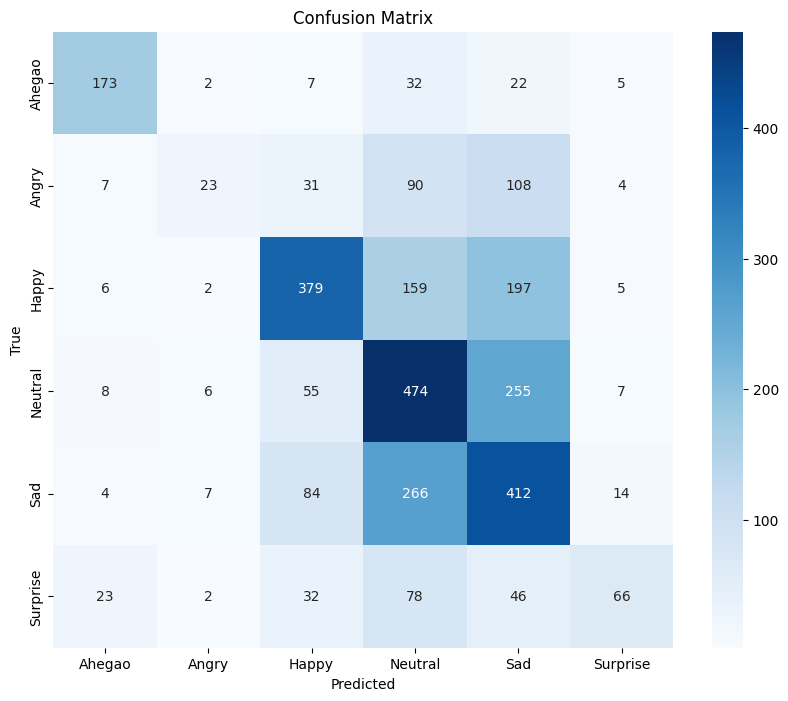

In [21]:
#Evalute the model
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis = 1)
y_true = test_data['label'].apply(lambda x: train_generator.class_indices[x]).values

#auc and confusion matrix 
auc = roc_auc_score(y_true, predictions, multi_class='ovr')
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

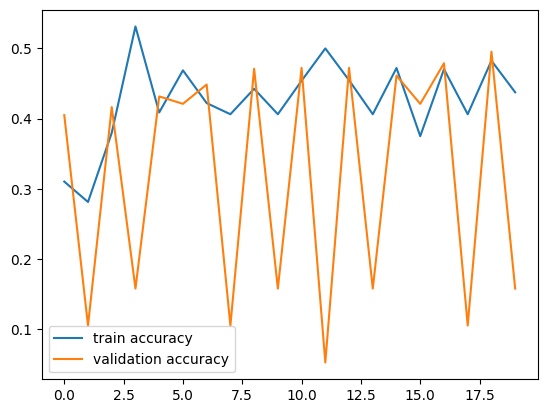

In [22]:
#graph for accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()


In [23]:
def preprocess_image_for_model(img_path):
    image = cv2.imread(img_path)
    image = cv2.resize(image, IMG_SIZE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = preprocess_input(image)
    return image[np.newaxis, ...]
# Example function to predict using the model
def predict_function(images):
    return model.predict(images)

In [24]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

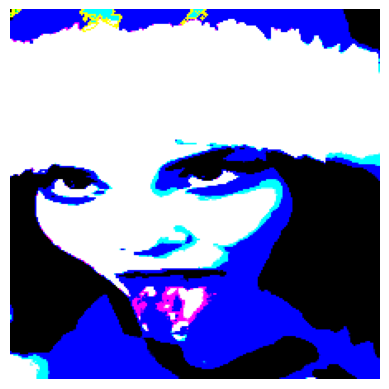

In [25]:
# Example image path for interpretation
img_path = '/kaggle/input/faceexpression-dp/dataset/Ahegao/cropped_emotions.16183~ahegao.png'

# Preprocess the image for model prediction
img = preprocess_image_for_model(img_path)

# Generate explanation
explanation = explainer.explain_instance(
    img[0],  # Pass the image array (without batch dimension)
    predict_function,  # Model prediction function
    top_labels=5,  # Number of top labels to explain
    hide_color=0,  # Color for areas not to be explained (0 for black)
    num_samples=1000,  # Number of images to generate for LIME's explanation
    segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
)

# Show explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # Top label index to explain
    positive_only=False,  # If True, only the areas that contribute to the prediction are shown
    num_features=5,  # Number of superpixels to include in explanation visualization
    hide_rest=False  # If True, superpixels not included in explanation are hidden
)

# Visualize explanation
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))  # Overlay image and mask
plt.axis('off')
plt.show()

1st Tuning

In [34]:
#Load VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding additional layers with Batch Normalization and Dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for Early Stopping, Model Checkpoint, and Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Initial training
EPOCHS = 50
BATCH_SIZE = 32

start_time = time.time()
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)
end_time = time.time()
print("Initial Training time in Minutes: ", round((end_time - start_time) / 60, 3))


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 217s 542ms/step - accuracy: 0.3052 - loss: 1.8930 - val_accuracy: 0.3424 - val_loss: 1.5576 - learning_rate: 1.0000e-04
Epoch 2/50
  1/386 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.3438 - loss: 1.7060

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3438 - loss: 1.7060 - val_accuracy: 0.1053 - val_loss: 530.0134 - learning_rate: 1.0000e-04
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 205s 522ms/step - accuracy: 0.4545 - loss: 1.4494 - val_accuracy: 0.3766 - val_loss: 1.5115 - learning_rate: 1.0000e-04
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 159us/step - accuracy: 0.5312 - loss: 1.1819 - val_accuracy: 0.4211 - val_loss: 236.5800 - learning_rate: 1.0000e-04
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 207s 528ms/step - accuracy: 0.4738 - loss: 1.3519 - val_accuracy: 0.3717 - val_loss: 1.5565 - learning_rate: 1.0000e-04
Epoch 6/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 162us/step - accuracy: 0.6562 - loss: 0.9076 - val_accuracy: 0.0526 - val_loss: 33.8467 - learning_rate: 1.0000e-04
Epoch 7/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 206s 523ms/step - accuracy: 0.4918 - loss: 1.2910 - val_accuracy: 0.4183 - val_loss: 1.3737 - learning_rate: 1.0000e-04
Epoch 8/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 163us/step 

In [35]:

# Evaluate the model
evaluation = model.evaluate(test_generator)
print("Evaluation metrics: ", evaluation)

97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step - accuracy: 0.3953 - loss: 1.4206
Evaluation metrics:  [2.4181013107299805, 0.41766420006752014]


97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step


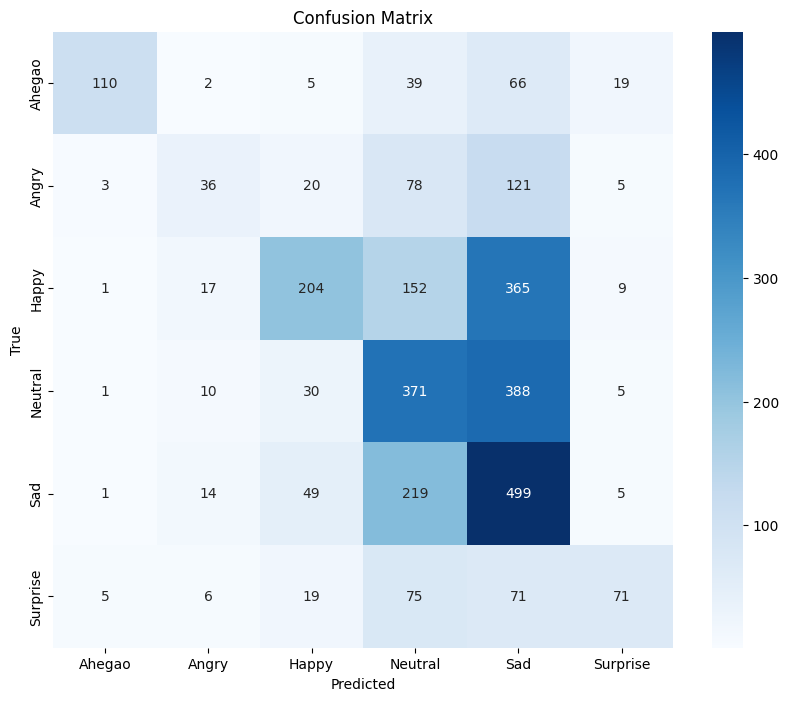

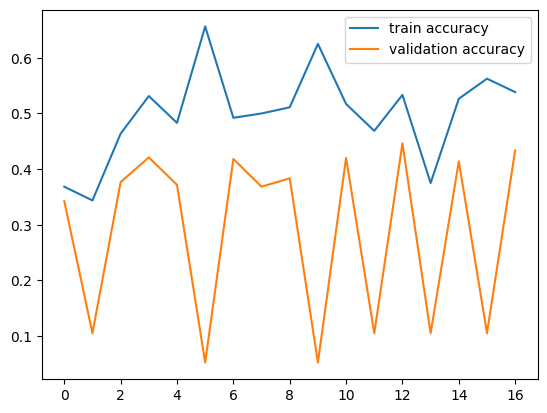

In [36]:
#Evalute the model
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis = 1)
y_true = test_data['label'].apply(lambda x: train_generator.class_indices[x]).values

#auc and confusion matrix 
auc = roc_auc_score(y_true, predictions, multi_class='ovr')
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#graph for accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()


In [37]:
def preprocess_image_for_model(img_path):
    image = cv2.imread(img_path)
    image = cv2.resize(image, IMG_SIZE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = preprocess_input(image)
    return image[np.newaxis, ...]
# Example function to predict using the model
def predict_function(images):
    return model.predict(images)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

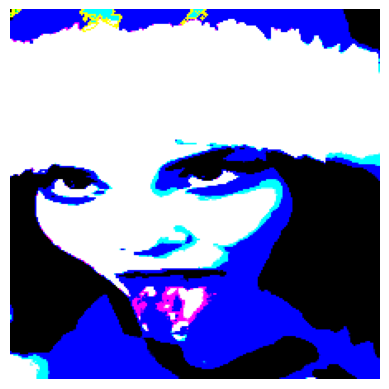

In [38]:
# Example image path for interpretation
img_path = '/kaggle/input/faceexpression-dp/dataset/Ahegao/cropped_emotions.16183~ahegao.png'

# Preprocess the image for model prediction
img = preprocess_image_for_model(img_path)

# Generate explanation
explanation = explainer.explain_instance(
    img[0],  # Pass the image array (without batch dimension)
    predict_function,  # Model prediction function
    top_labels=5,  # Number of top labels to explain
    hide_color=0,  # Color for areas not to be explained (0 for black)
    num_samples=1000,  # Number of images to generate for LIME's explanation
    segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
)

# Show explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # Top label index to explain
    positive_only=False,  # If True, only the areas that contribute to the prediction are shown
    num_features=5,  # Number of superpixels to include in explanation visualization
    hide_rest=False  # If True, superpixels not included in explanation are hidden
)

# Visualize explanation
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))  # Overlay image and mask
plt.axis('off')
plt.show()

In [39]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)
end_time = time.time()
print("Fine-Tuning Training time in Minutes: ", round((end_time - start_time) / 60, 3))


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 217s 542ms/step - accuracy: 0.5033 - loss: 1.2377 - val_accuracy: 0.3760 - val_loss: 1.4590 - learning_rate: 1.0000e-05
Epoch 2/50
  1/386 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.4688 - loss: 1.5714

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4688 - loss: 1.5714 - val_accuracy: 0.1053 - val_loss: 74.1941 - learning_rate: 1.0000e-05
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 208s 529ms/step - accuracy: 0.5075 - loss: 1.2338 - val_accuracy: 0.4251 - val_loss: 1.3747 - learning_rate: 1.0000e-05
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 166us/step - accuracy: 0.4375 - loss: 1.3036 - val_accuracy: 0.1579 - val_loss: 60.0159 - learning_rate: 1.0000e-05
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 207s 527ms/step - accuracy: 0.5130 - loss: 1.2351 - val_accuracy: 0.4339 - val_loss: 1.3716 - learning_rate: 1.0000e-05
Epoch 6/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 160us/step - accuracy: 0.4062 - loss: 1.4837 - val_accuracy: 0.2105 - val_loss: 31.8454 - learning_rate: 1.0000e-05
Epoch 7/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 208s 531ms/step - accuracy: 0.5133 - loss: 1.2115 - val_accuracy: 0.4176 - val_loss: 1.3719 - learning_rate: 1.0000e-05
Epoch 8/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 160us/step - 

In [40]:
# Evaluate the fine-tuned model
evaluation = model.evaluate(test_generator)
print("Fine-Tuning Evaluation metrics: ", evaluation)

97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 0.4287 - loss: 1.3881
Fine-Tuning Evaluation metrics:  [1.7063316106796265, 0.4416046440601349]


97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step


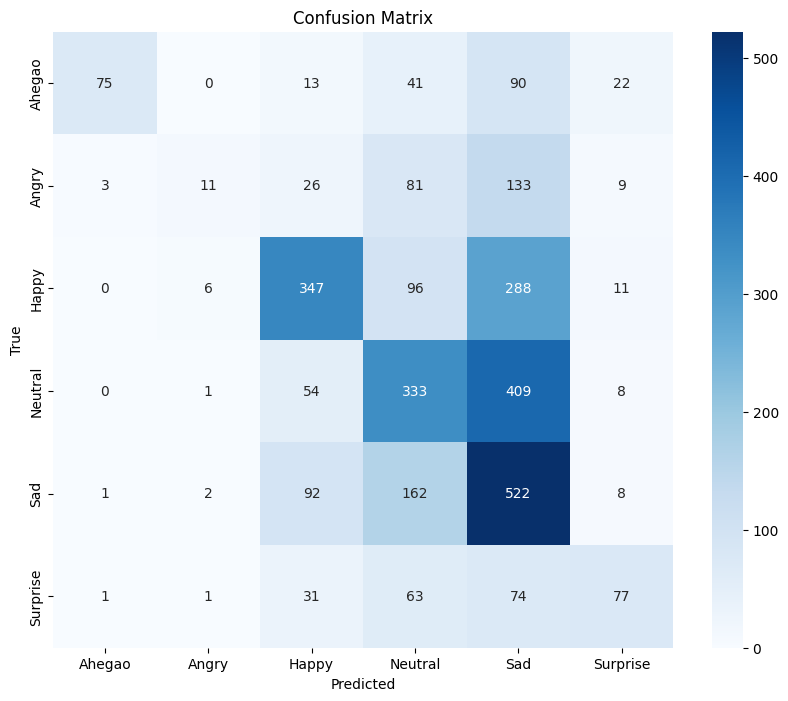

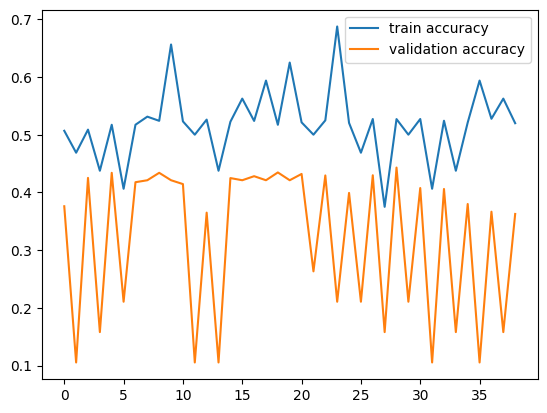

In [41]:
#Evalute the model
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis = 1)
y_true = test_data['label'].apply(lambda x: train_generator.class_indices[x]).values

#auc and confusion matrix 
auc = roc_auc_score(y_true, predictions, multi_class='ovr')
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#graph for accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()


In [42]:
def preprocess_image_for_model(img_path):
    image = cv2.imread(img_path)
    image = cv2.resize(image, IMG_SIZE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = preprocess_input(image)
    return image[np.newaxis, ...]
# Example function to predict using the model
def predict_function(images):
    return model.predict(images)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

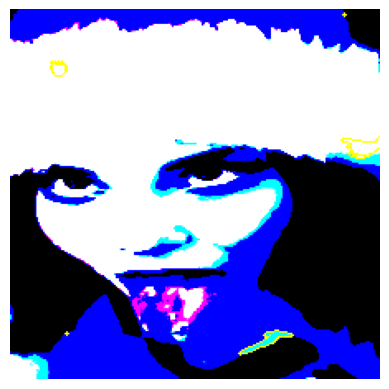

In [43]:
# Example image path for interpretation
img_path = '/kaggle/input/faceexpression-dp/dataset/Ahegao/cropped_emotions.16183~ahegao.png'

# Preprocess the image for model prediction
img = preprocess_image_for_model(img_path)

# Generate explanation
explanation = explainer.explain_instance(
    img[0],  # Pass the image array (without batch dimension)
    predict_function,  # Model prediction function
    top_labels=5,  # Number of top labels to explain
    hide_color=0,  # Color for areas not to be explained (0 for black)
    num_samples=1000,  # Number of images to generate for LIME's explanation
    segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
)

# Show explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # Top label index to explain
    positive_only=False,  # If True, only the areas that contribute to the prediction are shown
    num_features=5,  # Number of superpixels to include in explanation visualization
    hide_rest=False  # If True, superpixels not included in explanation are hidden
)

# Visualize explanation
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))  # Overlay image and mask
plt.axis('off')
plt.show()